# Project: Analyzing a Market Test

### Project Overview

*You're a business analyst for Round Roasters, a coffee restaurant in the United States of America. The executive team conducted a market test with a new menu and needs to figure whether the new menu can drive enough sales to offset the cost of marketing the new menu. Your job is to analyze the A/B test and write up a recommendation to whether the Round Roasters chain should launch this new menu.*

#### Required packages for the analysis

In [1]:
import os, sys, glob
from datetime import datetime, timedelta
from Functions import *
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## Step 1: Plan Your Analysis

### 1.	What is the performance metric you’ll use to evaluate the results of your test?

***Gross Margin*** *is the performance metric that will be used to determine if the launch of a new menu on specific stores will increase incomes.*

### 2.	What is the test period?

*The test period is composed by dates within the range* ***2016-April-29*** *to* ***2016-July-21***

### 3.	At what level (day, week, month, etc.) should the data be aggregated?

*The data will be aggregated* ***weekly***

## Step 2: Clean Up Your Data 

### 1. ETL

#### Loading data

In [2]:
path = os.path.join(os.getcwd(), 'Data')

filename_trans = 'RoundRoastersTransactions.csv'
filename_treats = 'treatment-stores (1).csv'
filename_stores = 'round-roaster-stores (1).csv'
            
df_trans = pd.read_csv(os.path.join(path, filename_trans))
df_treats = pd.read_csv(os.path.join(path, filename_treats))
df_stores = pd.read_csv(os.path.join(path, filename_stores))

#### Missing values in loaded data

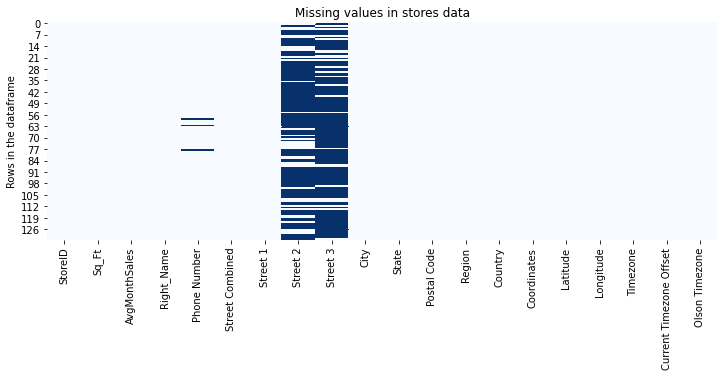

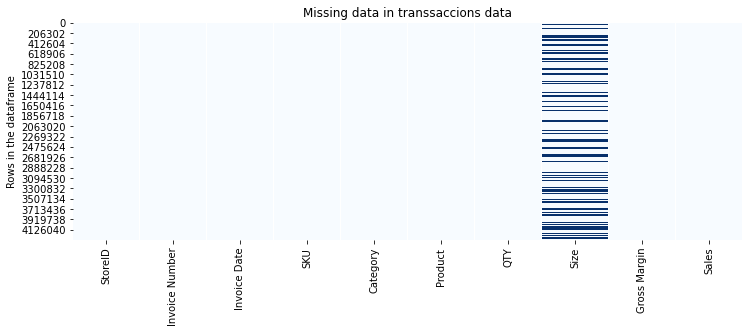

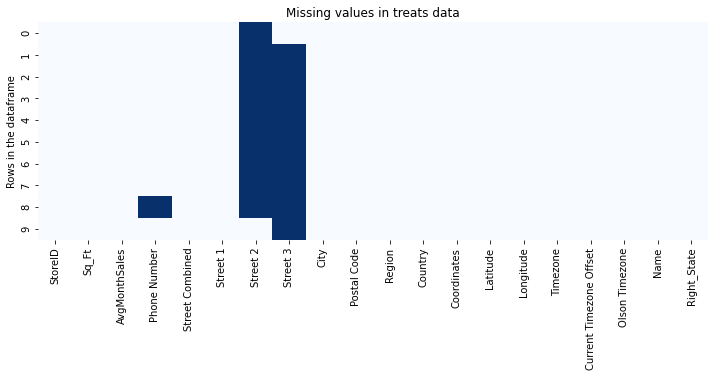

In [3]:
titles = ['Missing values in stores data', 'Missing data in transsaccions data',
          'Missing values in treats data']

for i, dataframe in enumerate([df_stores, df_trans, df_treats]):
    fig, ax = plt.subplots(figsize=(12,4))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='Blues')
    plt.title(titles[i])
    plt.ylabel('Rows in the dataframe')

#### Removing missing values

In [4]:
df_stores.drop(['Street 2', 'Street 3'], axis=1, inplace=True)
df_trans.drop('Size', axis=1, inplace=True)
df_treats.drop(['Street 2', 'Street 3'], axis=1, inplace=True)

#### Types of data within the dataframe

In [5]:
titles = ['Types of data in the store dataset', 'Types of data in the transactions dataset', 
          'Types of data in the treats dataset']

for i, dataframe in enumerate([df_stores, df_trans, df_treats]):
    print(titles[i]+ ':')
    display(dataframe.dtypes)

Types of data in the store dataset:


StoreID                      int64
Sq_Ft                        int64
AvgMonthSales                int64
Right_Name                  object
Phone Number                object
Street Combined             object
Street 1                    object
City                        object
State                       object
Postal Code                  int64
Region                      object
Country                     object
Coordinates                 object
Latitude                   float64
Longitude                  float64
Timezone                    object
Current Timezone Offset      int64
Olson Timezone              object
dtype: object

Types of data in the transactions dataset:


StoreID             int64
Invoice Number      int64
Invoice Date       object
SKU                 int64
Category           object
Product            object
QTY                 int64
Gross Margin      float64
Sales             float64
dtype: object

Types of data in the treats dataset:


StoreID                      int64
Sq_Ft                        int64
AvgMonthSales                int64
Phone Number                object
Street Combined             object
Street 1                    object
City                        object
Postal Code                  int64
Region                      object
Country                     object
Coordinates                 object
Latitude                   float64
Longitude                  float64
Timezone                    object
Current Timezone Offset      int64
Olson Timezone              object
Name                        object
Right_State                 object
dtype: object

#### Generating date variables for the analysis

In [6]:
df_trans['Invoice Date'] = pd.to_datetime(df_trans['Invoice Date'])
df_trans.head()

,StoreID,Invoice Number,Invoice Date,SKU,Category,Product,QTY,Gross Margin,Sales
0,10018,16296643,2015-01-21,1043,Espresso,Mocha,3,6.7365,14.97
1,10018,16296643,2015-01-21,2001,Pastry,Croissant,1,1.1000,2.75
2,10018,16297717,2015-01-21,1021,Espresso,Espresso,3,4.1850,8.37
3,10018,16297717,2015-01-21,1022,Espresso,Espresso,4,5.9800,11.96
4,10018,16297717,2015-01-21,1023,Espresso,Espresso,3,4.7850,9.57


#### Removing unnecessary features

In [7]:
df_treats.drop(['Phone Number', 'Street Combined', 'Country', 'Street 1', 'Latitude', 
                'Longitude', 'Olson Timezone', 'Current Timezone Offset', 'Postal Code',
               'Name', 'Timezone'], axis=1, inplace=True)
df_stores.drop(['Phone Number', 'Street Combined', 'Country', 'Street 1', 'Latitude', 
                'Longitude', 'Olson Timezone', 'Current Timezone Offset', 'Postal Code',
               'Right_Name', 'Timezone'], axis=1, inplace=True)

#### Renaming features

In [8]:
df_treats.rename(columns={'Right_State':'State'}, inplace=True)

df_stores.rename(columns={'Right_Name':'Store_Name'}, inplace=True)

df_stores = df_stores[df_treats.columns]

df_trans.rename(columns={'Invoice Number':'Invoice_Number', 'Invoice Date':'Invoice_Date',
                        'Gross Margin':'Gross_Margin'}, inplace=True)

### 2. Data Processing

#### Combining dataframes for the analysis

In [9]:
df = df_trans.merge(df_stores, left_on='StoreID', right_on='StoreID', suffixes=(False, False), how='left')

#### Reducing range of dates

In [10]:
Format='%y/%m/%d'
datetime_ctr = ['15/02/06', '16/07/21']
datetime_ctr = [datetime.strptime(datetime_ctr[0], Format).date(), datetime.strptime(datetime_ctr[1], Format).date()]
df = df[(df['Invoice_Date'] >= np.datetime64(datetime_ctr[0])) & 
                     (df['Invoice_Date'] <= np.datetime64(datetime_ctr[1]))]

#### Generating week related features

In [11]:
# Defining date reference, first date valid for the analysis
datetime_ctr = ['15/02/06', '16/07/21']
date_ref = datetime.strptime(datetime_ctr[0], Format).date()

# Generating Week, Start Week and End Week features
df.loc.__setitem__((slice(None), 'Week'), (df.Invoice_Date - np.datetime64(date_ref)).dt.days)
df.Week = df.Week.apply(lambda x:int(np.floor(x/7)+1))
df.loc.__setitem__((slice(None), 'Week_Start'), pd.to_datetime([date_ref + timedelta(days=7*(week-1)) 
                                                                for week in df.Week]))
df.loc.__setitem__((slice(None), 'Week_End'), pd.to_datetime([fecha + timedelta(days=6) 
                                                                for fecha in df.Week_Start]))

# Validating the number of weeks per store 
df_temp = df.groupby(['StoreID']).Week.nunique().to_frame()
df_temp.reset_index(inplace=True)
df = df[df.StoreID.isin(df_temp[df_temp.Week >= 76].StoreID)]

display(df.head())

,StoreID,Invoice_Number,Invoice_Date,SKU,Category,Product,QTY,Gross_Margin,Sales,Sq_Ft,AvgMonthSales,City,Region,Coordinates,State,Week,Week_Start,Week_End
628,10018,16551067,2015-02-06,1013,Espresso,Cappuccino,2,4.7880,7.98,1183,18000,Long Beach,West,"(33.8085823059082, -118.124931335449)",CA,1,2015-02-06,2015-02-12
629,10018,16551067,2015-02-06,1022,Espresso,Espresso,1,1.4950,2.99,1183,18000,Long Beach,West,"(33.8085823059082, -118.124931335449)",CA,1,2015-02-06,2015-02-12
630,10018,16551067,2015-02-06,1023,Espresso,Espresso,3,4.7850,9.57,1183,18000,Long Beach,West,"(33.8085823059082, -118.124931335449)",CA,1,2015-02-06,2015-02-12
631,10018,16551067,2015-02-06,1041,Espresso,Mocha,1,1.7955,3.99,1183,18000,Long Beach,West,"(33.8085823059082, -118.124931335449)",CA,1,2015-02-06,2015-02-12
632,10018,16551067,2015-02-06,1042,Espresso,Mocha,3,6.0615,13.47,1183,18000,Long Beach,West,"(33.8085823059082, -118.124931335449)",CA,1,2015-02-06,2015-02-12


#### Grouping features to understand the availbale data for the problem

In [12]:
# Grouping features to measure the amount of sales and gross marging per stores with similar characteristics
df_feat = df.groupby(['Region', 'StoreID', 'Invoice_Number', 'Week', 'Week_Start', 'Week_End', 'AvgMonthSales'])[
                            ['Sales', 'Gross_Margin']].sum()
df_feat.reset_index(inplace=True)
df_feat['CountUnique_Invoice_Number'] = df.groupby(['Region', 'StoreID', 'Invoice_Number', 'Week', 'Week_Start', 'Week_End', 'AvgMonthSales']).Invoice_Number.nunique().values
display(df_feat.head())

,Region,StoreID,Invoice_Number,Week,Week_Start,Week_End,AvgMonthSales,Sales,Gross_Margin,CountUnique_Invoice_Number
0,Central,1508,16546560,1,2015-02-06,2015-02-12,12000,51.86,24.5310,1
1,Central,1508,16547721,1,2015-02-06,2015-02-12,12000,26.73,12.5660,1
2,Central,1508,16547904,1,2015-02-06,2015-02-12,12000,30.06,14.7550,1
3,Central,1508,16547929,1,2015-02-06,2015-02-12,12000,31.11,17.1510,1
4,Central,1508,16548927,1,2015-02-06,2015-02-12,12000,47.14,24.3405,1


### 3. Determining the number of weekly number of transactions and gross margin per store

In [13]:
df_week_sales = df_feat.groupby(['StoreID', 'Week', 'Week_Start', 'Week_End'])['CountUnique_Invoice_Number', 'Gross_Margin'].sum()
df_week_sales.reset_index(inplace=True)
display(df_week_sales.head())

<ipython-input-13-76740056842f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_week_sales = df_feat.groupby(['StoreID', 'Week', 'Week_Start', 'Week_End'])['CountUnique_Invoice_Number', 'Gross_Margin'].sum()


,StoreID,Week,Week_Start,Week_End,CountUnique_Invoice_Number,Gross_Margin
0,1508,1,2015-02-06,2015-02-12,183,1429.4390
1,1508,2,2015-02-13,2015-02-19,273,2031.2580
2,1508,3,2015-02-20,2015-02-26,153,1022.0430
3,1508,4,2015-02-27,2015-03-05,210,1372.2495
4,1508,5,2015-03-06,2015-03-12,239,1698.8590


### 4. Determining the regional sales and gross margin per store

In [14]:
df_region_sales = df_feat.groupby(['Region', 'StoreID', 'Week', 'Week_Start', 'Week_End'])['Gross_Margin', 'Sales'].sum()
df_region_sales.reset_index(inplace=True)
display(df_region_sales.head())

<ipython-input-14-eec70c437420>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_region_sales = df_feat.groupby(['Region', 'StoreID', 'Week', 'Week_Start', 'Week_End'])['Gross_Margin', 'Sales'].sum()


,Region,StoreID,Week,Week_Start,Week_End,Gross_Margin,Sales
0,Central,1508,1,2015-02-06,2015-02-12,1429.4390,3124.61
1,Central,1508,2,2015-02-13,2015-02-19,2031.2580,4360.54
2,Central,1508,3,2015-02-20,2015-02-26,1022.0430,2217.27
3,Central,1508,4,2015-02-27,2015-03-05,1372.2495,2996.95
4,Central,1508,5,2015-03-06,2015-03-12,1698.8590,3704.73


### 5. Defining the possible control and treatment units

In [15]:
# Treatment units
df_treats.loc.__setitem__((slice(None), 'Test_Group'), 'Treatment')

# Control units
df_temp = df_feat.groupby(['Region', 'StoreID', 'AvgMonthSales']).Sales.sum().to_frame()
df_temp.reset_index(inplace=True)
df_units = df_temp[df_temp.columns[0:-1]].merge(df_treats[['StoreID', 'AvgMonthSales', 'Test_Group']], left_on=['StoreID', 'AvgMonthSales'], right_on=['StoreID', 'AvgMonthSales'], suffixes=(None, True), how='left')
df_units.loc.__setitem__((df_units[df_units.Test_Group != 'Treatment'].index, 'Test_Group'), 'Control')
display(df_units.head(10))

,Region,StoreID,AvgMonthSales,Test_Group
0,Central,1508,12000,Control
1,Central,1542,12000,Control
2,Central,1580,14000,Control
3,Central,1630,17000,Control
4,Central,1662,11000,Control
5,Central,1664,11000,Treatment
6,Central,1675,15000,Treatment
7,Central,1696,10000,Treatment
8,Central,1700,15000,Treatment
9,Central,1712,19000,Treatment


## Step 3: Match Treatment and Control Units

### 1.	What control variables should be considered?

The following control variables will be considered. This, since all stores of interest share features that represent those characteristics.

In [16]:
ctrl_vars = ['Sq_Ft', 'AvgMonthSales', 'City', 'Region','State']
treat_var = ['Gross_Margin']

### 2. Correlation between your each potential control variable and your performance metric?
#### (Criteria: Control Variables)

The amount of dependency among the possible control variables and the performance metric are presented next, as a table and graphically.

#### Correlation matrix and graphical representation of the relationships

,Sq_Ft,AvgMonthSales,City,Region,State,Gross_Margin
Sq_Ft,1.000000,-0.046967,-0.175128,-0.056715,0.417254,-0.020353
AvgMonthSales,-0.046967,1.000000,0.126120,0.197643,-0.138001,0.988219
City,-0.175128,0.126120,1.000000,0.212028,-0.196366,0.110179
Region,-0.056715,0.197643,0.212028,1.000000,-0.431389,0.169105
State,0.417254,-0.138001,-0.196366,-0.431389,1.000000,-0.125103
Gross_Margin,-0.020353,0.988219,0.110179,0.169105,-0.125103,1.000000


<Figure size 720x720 with 0 Axes>

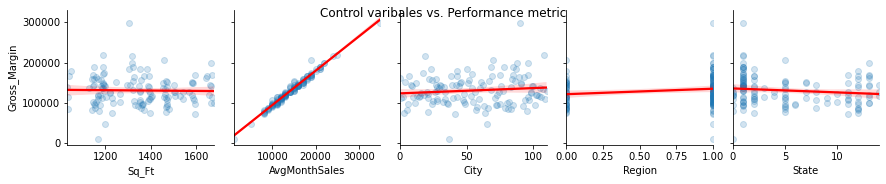

In [17]:
Corr_Control_Variables(df_stores, df_trans, ctrl_vars, treat_var)

It can be observed that the AvgMonthSales and Region are the more correlated features with respect to the performance metric, and therefore, those will be considered as control variables, together with the trend and seasonality characteristics.

### 3.	What control variables will you use to match treatment and control stores?

In addition to the previously defined control variables, the trend and seasonality of the stores incomes should be analyzed for a more robust analysis. As result, three different scenarios are implemented to understand how stores behave in terms of the amount of unique invoices generated per specific dates, or weeks in this case. 

#### Trend and Seasonality per periods

The trend and seasonality analysis is justified by comparing the performance metric between two treatment units and the rest of the available stores to analyze for a specific period of time. It can be observed that both of those class of stores share a similar behaviour with respect to their gross margins per week.

/Users/alfdelucio/Desktop/alfdrive/Cursos/PredictiveAnalytics/ABTest/Functions.py:189: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df_trans[df_trans.Label==label].groupby(['StoreID', 'Week'])['Sales', 'Gross_Margin', 'QTY'].sum()


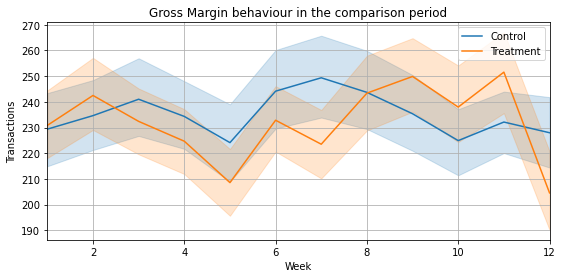

In [18]:
plot_trend(df_trans, df_treats)

#### Trend and Seasonality per store to analyze

The trend and seasonality of the stores will be found based on a k-mean algorithm, to be more specific on the implementation of a ***KDE tree*** from the ***scikit_learn*** library. Nonetheless, as found in the previous section, the *AvgMonthSales* and the *Region* features need to be considered as well

- Considering the AvgMonthSales feature

    This feature will be considered by analyzing only those stores that share similar monthly average sales as the treatment units, which statistics are presented next:
    

In [19]:
df_treats.AvgMonthSales.describe().to_frame()

,AvgMonthSales
count,10.000000
mean,13100.000000
std,2806.737925
min,10000.000000
25%,11000.000000
50%,12500.000000
75%,14750.000000
max,19000.000000


Thus, only stores with average monthly sales of 10000 to 20000 will be considered. It can also be considered the *std*, but for this implementation that won't be the case. The *Region* characteristic will be considered as presented next, for each of the available regions and considering all regions as well. 

In [20]:
comp_period = ['15/04/29', '15/07/21']
test_period = ['16/04/29', '16/07/21']
trend_period = ['15/02/12', '16/04/28']
dates = [trend_period, test_period]

- ***Trends Among Treatment and Controls Stores for the Central Region***

In [21]:
Central_stores = Closest_Stores(df_stores, df_week_sales, df_treats, ['Central'], [10000, 20000], dates)
Central_stores.head(10)

,Target,Ctrl_1,Ctrl_2,Dist2Crtl_1,Dist2Crtl_2,AvgSales_Tar,AvgSales_Ctr1,AvgSales_Ctr2
0,1664,1662,1964,324.000000,349.0,11000,11000,11000
1,1675,1857,7284,150.000000,452.0,15000,15000,15000
2,1696,7811,7384,194.000000,630.0,10000,10000,10000
3,1700,7484,2214,110.000000,626.0,15000,15000,15000
4,1712,2114,8312,1130.366755,1230.0,19000,20000,19000


- ***Trends Among Treatment and Controls Stores for the West Region***

In [22]:
West_stores = Closest_Stores(df_stores, df_week_sales, df_treats, ['West'], [10000, 20000], dates)
West_stores.head(10)

,Target,Ctrl_1,Ctrl_2,Dist2Crtl_1,Dist2Crtl_2,AvgSales_Tar,AvgSales_Ctr1,AvgSales_Ctr2
0,2288,9438,8817,1.000000,44.000000,14000,14000,14000
1,2293,9639,12019,131.000000,447.000000,11000,11000,11000
2,2301,2852,12286,749.000000,911.000000,11000,11000,11000
3,2322,9488,3235,427.000000,580.000000,14000,14000,14000
4,2341,9238,12219,1002.175633,1010.314802,11000,12000,12000


- ***General Trend Among Treatment and Controls Stores***

In [23]:
#Comp_stores = Closest_Stores(df_stores, df_week_sales, df_treats, ['Central','West'], [10000, 20000], dates)
Comp_stores = pd.concat([Central_stores, West_stores])
Comp_stores.reset_index(drop=True, inplace=True)
Comp_stores.head(10)

,Target,Ctrl_1,Ctrl_2,Dist2Crtl_1,Dist2Crtl_2,AvgSales_Tar,AvgSales_Ctr1,AvgSales_Ctr2
0,1664,1662,1964,324.000000,349.000000,11000,11000,11000
1,1675,1857,7284,150.000000,452.000000,15000,15000,15000
2,1696,7811,7384,194.000000,630.000000,10000,10000,10000
3,1700,7484,2214,110.000000,626.000000,15000,15000,15000
4,1712,2114,8312,1130.366755,1230.000000,19000,20000,19000
5,2288,9438,8817,1.000000,44.000000,14000,14000,14000
6,2293,9639,12019,131.000000,447.000000,11000,11000,11000
7,2301,2852,12286,749.000000,911.000000,11000,11000,11000
8,2322,9488,3235,427.000000,580.000000,14000,14000,14000
9,2341,9238,12219,1002.175633,1010.314802,11000,12000,12000


### 4.	Please fill out the table below with your treatment and control stores pairs:
#### (Criteria: Treatment and Control Stores)

- ***Central region treatment and control stores pairs***

In [24]:
Central_stores[Comp_stores.columns[:3]].rename(columns={'Target':'Treatment_Store',
                                                     'Ctrl_1':'Control_Store_1',
                                                     'Ctrl_2':'Control_Store_2'})

,Treatment_Store,Control_Store_1,Control_Store_2
0,1664,1662,1964
1,1675,1857,7284
2,1696,7811,7384
3,1700,7484,2214
4,1712,2114,8312


- ***West region treatment and control stores pairs***

In [25]:
West_stores[Comp_stores.columns[:3]].rename(columns={'Target':'Treatment_Store',
                                                     'Ctrl_1':'Control_Store_1',
                                                     'Ctrl_2':'Control_Store_2'})

,Treatment_Store,Control_Store_1,Control_Store_2
0,2288,9438,8817
1,2293,9639,12019
2,2301,2852,12286
3,2322,9488,3235
4,2341,9238,12219


- ***General treatment and control stores pairs***

In [26]:
Comp_stores[Comp_stores.columns[:3]].rename(columns={'Target':'Treatment_Store',
                                                     'Ctrl_1':'Control_Store_1',
                                                     'Ctrl_2':'Control_Store_2'})

,Treatment_Store,Control_Store_1,Control_Store_2
0,1664,1662,1964
1,1675,1857,7284
2,1696,7811,7384
3,1700,7484,2214
4,1712,2114,8312
5,2288,9438,8817
6,2293,9639,12019
7,2301,2852,12286
8,2322,9488,3235
9,2341,9238,12219


## Step 4: Analysis and Writeup

### 1.	What is your recommendation - Should the company roll out the updated menu to all stores? 

The launch of a new menu is highly recommended to our client to improve their incomes in terms of the weekly gross margin obtained per treatment store when compared to the control units gross margins. The justification can be observed below:

#### Gross Margins distributions

In the following figure can be observed the distribution of gross margins for the treatment and control units, for the comparison and test periods.

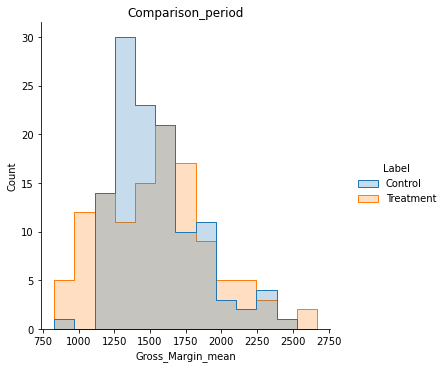

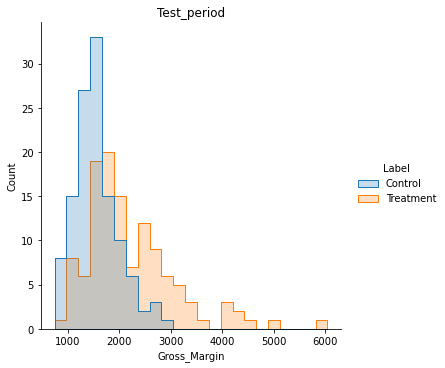

In [27]:
df_tar = Treatment_Dataframe(Comp_stores, df_region_sales, comp_period, test_period)
df_ctr = Control_Dataframe(Comp_stores, df_region_sales, comp_period, test_period)
Units_distributions(df_tar, df_ctr)

#### Gross margins 

In addition, the plotting of the gross margins for the treatment and control stores are presented next, for both periods mentioned above:

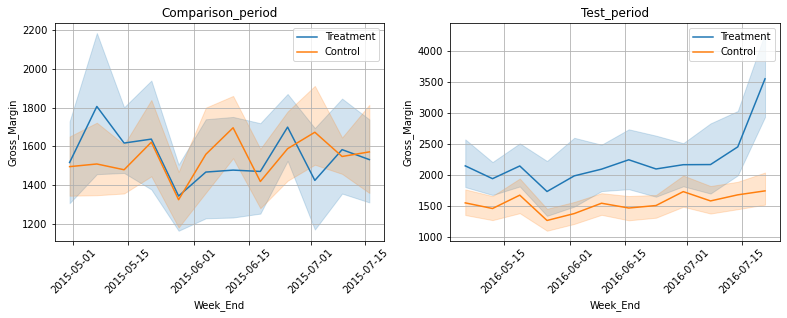

In [28]:
GrossMargin_plot(df_tar, df_ctr)

Thus, it can be concluded that the launch of a new menu will increase the gross margin feature for the analyzed stores, as shown in both figures with subfigures related to the test period.

### 2.	What is the lift from the new menu for West and Central regions (include statistical significance)? 

The gross margins improvements are presented next for each of the regions analyzed

- ***Central Region***

The change in weekly gross margin for the central region analyzed stores can be seen in the next figure, which presents the statistics for the gross margin for the treatment and control units for two different periods. It is clearly observable the increment in the gross margin statistics for the test period when compared against the comparison period. 

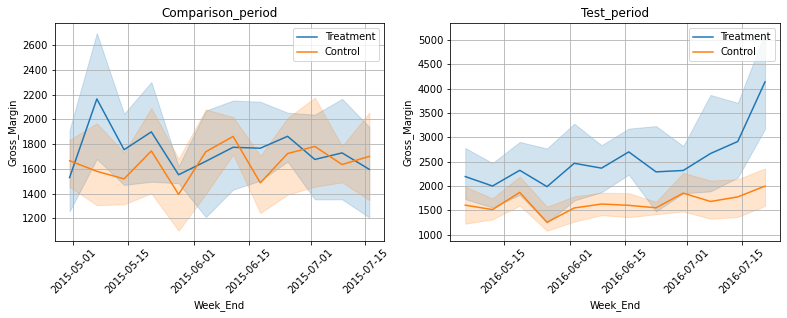

In [29]:
df_tar_central = Treatment_Dataframe(Central_stores, df_region_sales, comp_period, test_period)
df_ctr_central = Control_Dataframe(Central_stores, df_region_sales, comp_period, test_period)
GrossMargin_plot(df_tar_central, df_ctr_central)

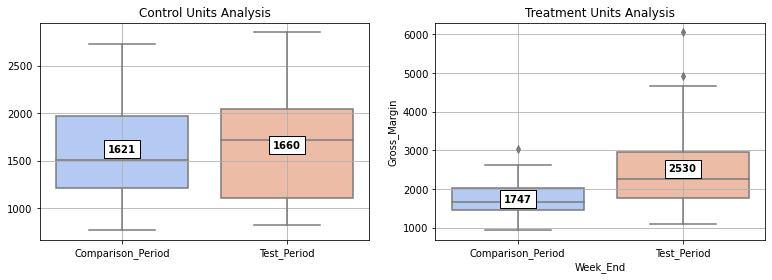

In [30]:
Boxplot2(df_tar_central, df_ctr_central)

This increment in the gross margin can be also observable with statistics, as presented next:

In [31]:
t_stat, pval, lift = Significance_Test2(df_tar_central, df_ctr_central, 'Treatment', 'Control')

,Values
T-stat.,6.81082
P-val,5.65073e-09
Avg_Lift,47.20 %
Avg_Lift_Treatment,44.80 %
Avg_Lift_Ctrl,2.40 %


Then, by analyzing the results it can be seen than the null hypothesis can be rejected, or that the new menu will result in better sales than the current menu for the stores in the central region. 

- ***West Region***

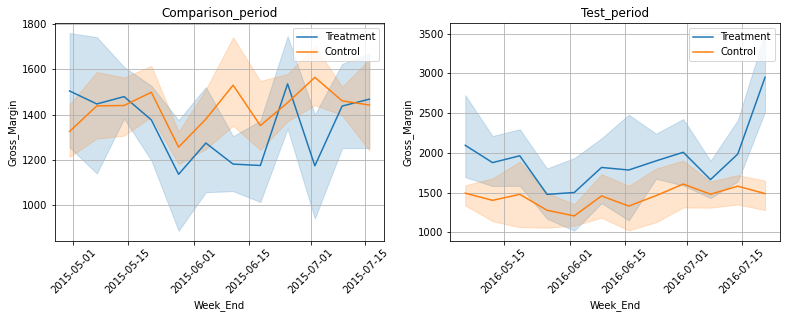

In [32]:
df_tar_west = Treatment_Dataframe(West_stores, df_region_sales, comp_period, test_period)
df_ctr_west = Control_Dataframe(West_stores, df_region_sales, comp_period, test_period)
GrossMargin_plot(df_tar_west, df_ctr_west)

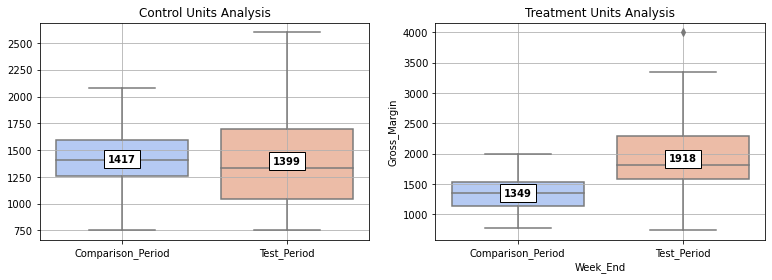

In [33]:
Boxplot2(df_tar_west, df_ctr_west)

In [34]:
t_stat, pval, lift= Significance_Test2(df_tar_west, df_ctr_west, 'Treatment', 'Control')

,Values
T-stat.,8.10972
P-val,3.57007e-11
Avg_Lift,40.90 %
Avg_Lift_Treatment,42.20 %
Avg_Lift_Ctrl,1.30 %


As in the Central region case, the launch of a new menu will increase sales in all stores present in the West region. 

### 3.	What is the lift from the new menu overall?

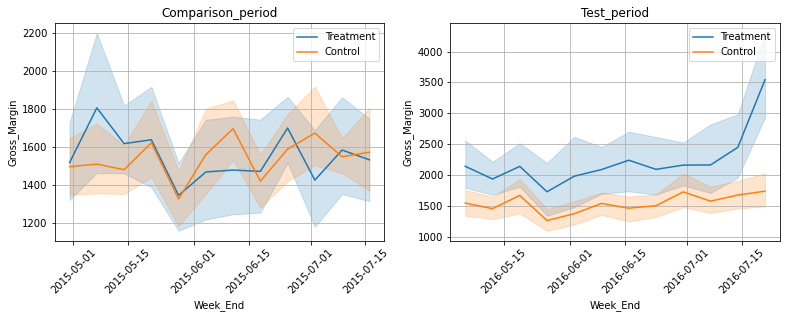

In [35]:
GrossMargin_plot(df_tar, df_ctr)

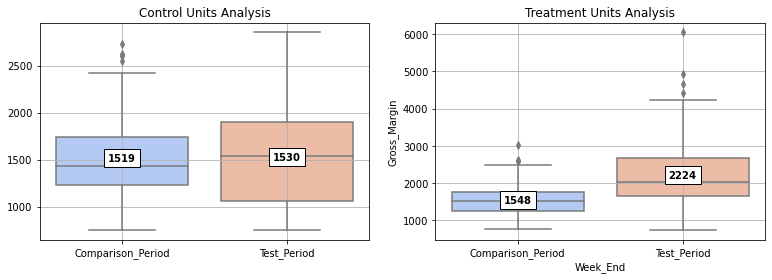

In [36]:
Boxplot2(df_tar, df_ctr)

In [37]:
t_stat, pval, lift, = Significance_Test2(df_tar, df_ctr, 'Treatment', 'Control')

,Values
T-stat.,9.97398
P-val,2.13752e-17
Avg_Lift,44.40 %
Avg_Lift_Treatment,43.70 %
Avg_Lift_Ctrl,0.70 %


As mentioned at the beginning of the section, the launch of a new menu is highly recommended for the client, as the obtained p-value let us know, for the overall analysis.

### FIN